# Case 1. No demography, no BGS effect. Alpha = 0.4, Alpha Weak = 0.2, Alpha Strong = 0.2

In [1]:
using Analytical, Plots, Plots.PlotMeasures, StatsPlots, LaTeXStrings, ProgressMeter, BenchmarkTools, DataFrames, CSV

In [2]:
function summStats(param::Analytical.parameters,iter::Int64,div::Array,sfs::Array,output::String,b::Int64,c::Float64)
	# @threads
	@showprogress for i in 1:iter
	# for i in 1:iter


		fac       = rand(-2:0.05:2)
		afac      = 0.184*(2^fac)
		bfac      = 0.000402*(2^fac)
		
		alTot     = rand(collect(0.05:0.01:0.4))
		alLow     = rand(collect(0.0:0.01:alTot))

		# println((thread=Threads.threadid(), iteration=i))
		bgsIter(param,afac,bfac,alTot,alLow,div,sfs,output,b,c)
	end
end

function bgsIter(param::Analytical.parameters,afac::Float64,bfac::Float64,alTot::Float64,alLow::Float64,div::Array,sfs::Array,output::String,b::Int64,c::Float64)

	for j in param.bRange
        # j = 0.999
        param.al = afac; param.be = bfac; 
        param.alLow = alLow; param.alTot = alTot; param.B = j

        Analytical.set_theta_f(param)
        theta_f = param.theta_f
        param.B = 0.999
        Analytical.set_theta_f(param)
        Analytical.setPpos(param)
        param.theta_f = theta_f
        param.B = j
        # x,y = Analytical.analyticalAlpha(param=param)
        x,y,z = Analytical.alphaByFrequencies(param,div,sfs,b,c)


        # println(z)

        Analytical.summaryStatistics(output, z)

		end
end

bgsIter (generic function with 1 method)

In [3]:
function plotPosterior(data,imgSize)

    Plots.gr()
    Plots.theme(:wong2)

    p1 = StatsPlots.density(data,
                            legend = :outertopright,
                            fill=(0, 0.75),
                            linecolor=["#30504f" "#e2bd9a" "#ab2710"],
                            #linecolor=["#E1B16A" "#31A2AC" "#F62A00"],        
                            fillcolor=["#30504f" "#e2bd9a" "#ab2710"],
                            xlabel = L"\alpha",
                            label = [L"\alpha" L"\alpha\_nopos - \alpha" L"\alpha\_nopos"],
                            ylabel = "Posterior density",
                            lw = 2,
                            fmt = :svg,
                            size=imgSize,
                        )
    return p1
    end

plotPosterior (generic function with 1 method)

In [4]:
gr()

Plots.GRBackend()

In [5]:
PATH="/home/jmurga/mkt/202004/rawData/"

"/home/jmurga/mkt/202004/rawData/"

## Loading data

Open simulated sfs accounting or not for weak selection

In [6]:
sfs = convert(Array,DataFrame!(CSV.File(PATH * "/simulations/noBgsNoDemog/sfsBgs.tsv")))
cSfs = convert.(Int64,Analytical.cumulativeSfs(sfs))

1321×4 Array{Int64,2}:
 26660  18396  533  26127
 20670  15802  482  20188
 18242  14612  461  17781
 16706  13838  444  16262
 15593  13198  431  15162
 14742  12678  418  14324
 14011  12291  404  13607
 13454  11937  397  13057
 12976  11630  389  12587
 12580  11349  383  12197
 12191  11113  376  11815
 11867  10905  366  11501
 11559  10715  362  11197
     ⋮                   
    29     34    6     23
    24     32    5     19
    22     31    4     18
    18     30    3     15
    15     26    2     13
    11     23    1     10
    11     22    1     10
     7     17    0      7
     5     15    0      5
     2      9    0      2
     1      6    0      1
     1      2    0      1

In [9]:
sfsPos = [cSfs[:,1] + cSfs[:,2] cSfs[:,1] + cSfs[:,2]];

In [10]:
sfsNopos = [cSfs[:,4] + cSfs[:,2] cSfs[:,4] + cSfs[:,2]];

Open simulated divergence

In [11]:
divergence = convert(Array,DataFrame!(CSV.File( PATH * "/simulations/noBgsNoDemog/divBgs.tsv")))
anDiv = [convert(Int64,sum(divergence)),convert(Int64,sum(divergence))];

In [12]:
divergence

1×2 Array{Float64,2}:
 450284.0  359149.0

Creating ABC input

In [ ]:
d        = DataFrame(convert.(Int64,divergence))
pn       = cSfs[1,1]
ps       = cSfs[1,2]
rSfs     = Analytical.reduceSfs(cSfs,100)'
alpha    = @. round(1 - divergence[2]/divergence[1] * rSfs[:,1]/rSfs[:,2],digits=5)'

inputAbc = hcat(d,DataFrame([pn ps]),DataFrame(alpha),makeunique=true)
CSV.write(PATH * "/observedInput/sfsNoBgsNoDemog.tsv", inputAbc, delim='\t',header=false);

Set up the model

In [ ]:
# Set up model
adap = Analytical.parameters(N=500,n=661,gam_neg=-457, gL=10,gH=500,B=0.999,alTot=0.4,alLow=0.4);
Analytical.binomOp(adap);

Run analytical approach with simulated data. I run the analysis in parallel using 8 cpus, about 30-40 minutes to perform 10^6 estimations. The first execution is just to compile the function.

In [ ]:
summStats(adap,1,anDiv,sfsPos,"/home/jmurga/test",100,0.9)

In [ ]:
# (8000replicates * 17bgsValues) * 8cpus ≈ 10^6
summStats(adap,8000,anDiv,sfsPos,"/home/jmurga/test",100,0.9)

## Original asymptotic values

In [13]:
al = @. 1 - divergence[2]/divergence[1] * (cSfs[:,1]/cSfs[:,2]);

In [14]:
al_nopos = @. 1 - divergence[2]/divergence[1] * (cSfs[:,4]/cSfs[:,2]);

Last alpha values are biased due to the amount of sites. However the asymptotic value is almost the expected (0.4)

In [15]:
hcat(cSfs[:,1],al,al_nopos)

1321×3 Array{Float64,2}:
 26660.0  -0.155912    -0.132803 
 20670.0  -0.0433177   -0.0189887
 18242.0   0.00424858   0.0294126
 16706.0   0.0370865    0.0626781
 15593.0   0.0576555    0.0837025
 14742.0   0.072543     0.0988404
 14011.0   0.0907777    0.116995 
 13454.0   0.101032     0.127558 
 12976.0   0.110083     0.136762 
 12580.0   0.11588      0.142797 
 12191.0   0.125024     0.15201  
 11867.0   0.132033     0.158802 
 11559.0   0.139569     0.166515 
     ⋮                           
    29.0   0.319689     0.460443 
    24.0   0.401796     0.526422 
    22.0   0.433957     0.536874 
    18.0   0.521437     0.601197 
    15.0   0.539843     0.601197 
    11.0   0.618536     0.653215 
    11.0   0.601197     0.637452 
     7.0   0.671574     0.671574 
     5.0   0.734131     0.734131 
     2.0   0.822754     0.822754 
     1.0   0.867066     0.867066 
     1.0   0.601197     0.601197 

In [16]:
Analytical.asympFit(al)

0.2930190461192779

In [17]:
Analytical.asympFit(al_nopos)

0.36532890435477866

Binning SFS to check alpha properly

In [18]:
rcSfs = Analytical.reduceSfs(cSfs,100)';

In [19]:
alBinned = @. 1 - divergence[2]/divergence[1] * (rcSfs[:,1]/rcSfs[:,2]);
al_noposBinned = @. 1 - divergence[2]/divergence[1] * (rcSfs[:,4]/rcSfs[:,2]);
hcat(alBinned,al_noposBinned)

100×2 Array{Float64,2}:
 0.0530832  0.0789398
 0.175943   0.203256 
 0.215159   0.243737 
 0.238497   0.267513 
 0.252229   0.281696 
 0.262863   0.292886 
 0.270791   0.302203 
 0.274848   0.307484 
 0.279685   0.313253 
 0.281314   0.315766 
 0.287003   0.322366 
 0.289959   0.326171 
 0.296133   0.333219 
 ⋮                   
 0.2609     0.393469 
 0.263269   0.39916  
 0.256482   0.400051 
 0.274684   0.419566 
 0.259664   0.417241 
 0.255701   0.412835 
 0.239946   0.40346  
 0.221558   0.389884 
 0.235741   0.39499  
 0.197903   0.373952 
 0.160557   0.329256 
 0.49089    0.572913 

In [20]:
hcat(Analytical.asympFit(alBinned),Analytical.asympFit(al_noposBinned))

1×2 Array{Float64,2}:
 0.296863  0.36706

True alphas from simulations

In [53]:
using StatsBase
alphas = convert(Array,DataFrame!(CSV.File(PATH * "/simulations/noBgsNoDemog/alphasBgs.tsv")))

10000×3 Array{Float64,2}:
 0.225806  0.225806  0.451613
 0.2       0.2       0.4     
 0.121951  0.121951  0.243902
 0.219512  0.219512  0.439024
 0.181818  0.181818  0.363636
 0.163934  0.163934  0.327869
 0.134615  0.134615  0.269231
 0.214286  0.214286  0.428571
 0.222222  0.222222  0.444444
 0.205128  0.205128  0.410256
 0.127273  0.127273  0.254545
 0.134615  0.134615  0.269231
 0.254545  0.254545  0.509091
 ⋮                           
 0.1875    0.1875    0.375   
 0.142857  0.142857  0.285714
 0.176471  0.176471  0.352941
 0.09375   0.09375   0.1875  
 0.170732  0.170732  0.341463
 0.104167  0.104167  0.208333
 0.117647  0.117647  0.235294
 0.204545  0.204545  0.409091
 0.176471  0.176471  0.352941
 0.16      0.16      0.32    
 0.218182  0.218182  0.436364
 0.159091  0.159091  0.318182

In [56]:
alphas = mean(alphas,dims=1)
DataFrame(trueAlphaStrong=alphas[1],
            trueAlphaWeak=alphas[2],
            trueAlpha=alphas[3],
            asympAlpha=Analytical.asympFit(al),
            asympAlpha_nopos=Analytical.asympFit(al_nopos)
)
≈

,trueAlphaStrong,trueAlphaWeak,trueAlpha,asympAlpha,asympAlpha_nopos
,Float64,Float64,Float64,Float64,Float64
1,0.176681,0.176681,0.353363,0.293019,0.365329


## ABC inference

In [21]:
p, r = Analytical.ABCreg(data="/home/jmurga/dataAbc/inputNoBgsNoDemog.tsv.gz",prior="/home/jmurga/dataAbc/slim1Cutoff.tsv.gz", nparams=3, nsummaries=104, outputPath="/home/jmurga/dataAbc/", outputPrefix="slim1", tolerance=0.001, regressionMode="T",regPath="/home/jmurga/ABCreg/src/reg");

In [32]:
DataFrame(alpha=r[1][:,1],alpha_noposMinusalpha=r[1][:,2],alpha_nopos=r[1][:,3])

,alpha,alpha_noposMinusalpha,alpha_nopos
,Float64,Float64,Float64
1,0.261325,0.108058,0.384289
2,0.254393,0.0915439,0.380689
3,0.268521,0.123138,0.388491


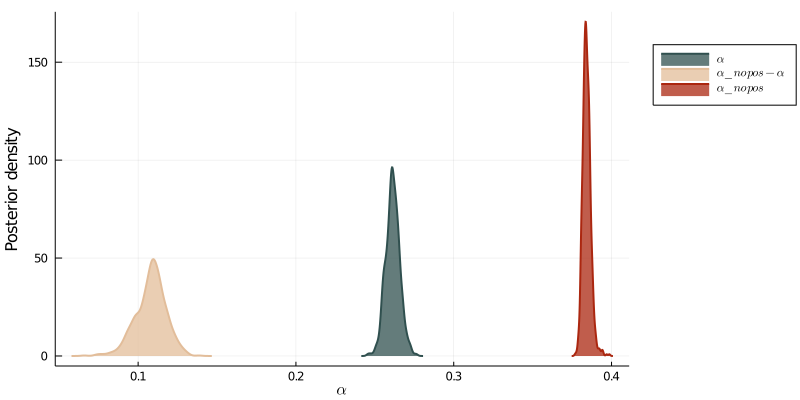

In [25]:
plotPosterior(p[1],(800,400))

In [66]:
p2, r2 = Analytical.ABCreg(data="/home/jmurga/dataAbc/sfsNoBgsNoDemog.tsv.gz",prior="/home/jmurga/dataAbc/sim.prop2.tsv.gz", nparams=3, nsummaries=104, outputPath="/home/jmurga/dataAbc/", outputPrefix="slim1", tolerance=0.0005, regressionMode="T",regPath="/home/jmurga/ABCreg/src/reg");

In [67]:
DataFrame(alpha=r2[1][:,1],alpha_noposMinusalpha=r2[1][:,2],alpha_nopos=r2[1][:,3])

,alpha,alpha_noposMinusalpha,alpha_nopos
,Float64,Float64,Float64
1,0.190726,0.187532,0.385547
2,0.129345,0.175476,0.379383
3,0.253144,0.200219,0.392977


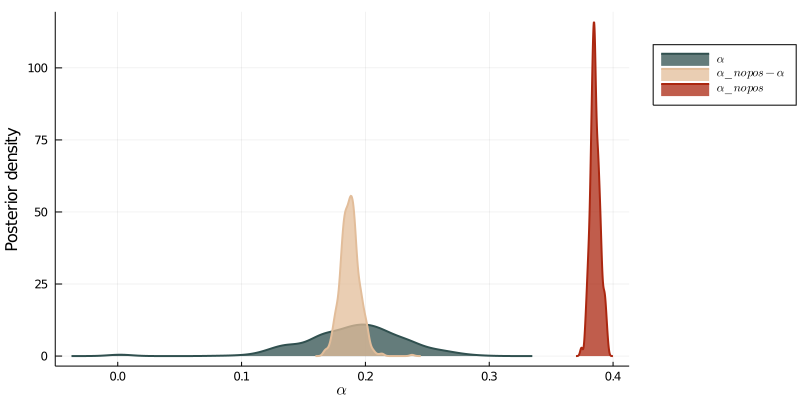

In [68]:
plotPosterior(p2[1],(800,400))

# Human proteins

In [36]:
allP, allR = Analytical.ABCreg(data="/home/jmurga/dataAbc/data1.tsv.gz",prior="/home/jmurga/dataAbc/protCutoffB1.tsv.gz", nparams=3, nsummaries=104, outputPath="/home/jmurga/dataAbc/", outputPrefix="prot1", tolerance=0.001, regressionMode="T",regPath="/home/jmurga/ABCreg/src/reg");

In [80]:
allP, allR = Analytical.ABCreg(data="/home/jmurga/dataAbc/data1.tsv.gz",prior="/home/jmurga/dataAbc/allPprop.tsv.gz", nparams=3, nsummaries=104, outputPath="/home/jmurga/dataAbc/", outputPrefix="prot1", tolerance=0.001, regressionMode="T",regPath="/home/jmurga/ABCreg/src/reg");

In [81]:
DataFrame(alpha=allR[1][:,1],alpha_noposMinusalpha=allR[1][:,2],alpha_nopos=allR[1][:,3])

,alpha,alpha_noposMinusalpha,alpha_nopos
,Float64,Float64,Float64
1,0.177949,0.0383371,0.153945
2,0.0276703,0.0317903,0.142113
3,0.358409,0.0448934,0.164394


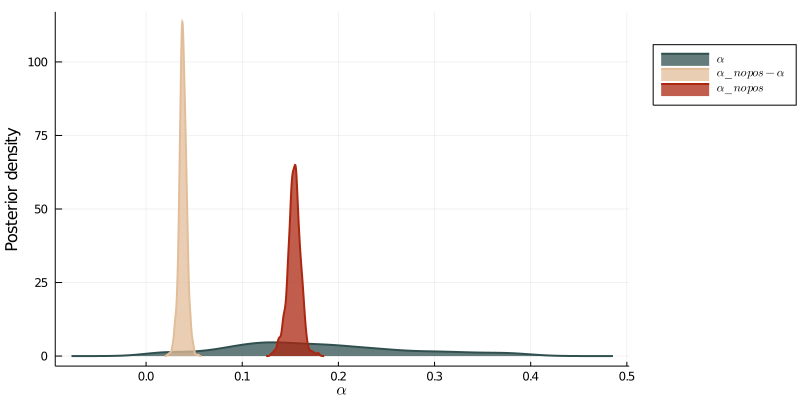

In [82]:
plotPosterior(allP[1],(800,400))

In [47]:
vipP, vipR = Analytical.ABCreg(data="/home/jmurga/dataAbc/data2.tsv.gz",prior="/home/jmurga/dataAbc/protCutoffB2.tsv.gz", nparams=3, nsummaries=104, outputPath="/home/jmurga/dataAbc/", outputPrefix="prot1", tolerance=0.001, regressionMode="T",regPath="/home/jmurga/ABCreg/src/reg");

In [77]:
vipP, vipR = Analytical.ABCreg(data="/home/jmurga/dataAbc/data2.tsv.gz",prior="/home/jmurga/dataAbc/vipProp.tsv.gz", nparams=3, nsummaries=104, outputPath="/home/jmurga/dataAbc/", outputPrefix="prot1", tolerance=0.001, regressionMode="T",regPath="/home/jmurga/ABCreg/src/reg");

In [78]:
DataFrame(alpha=vipR[1][:,1],alpha_noposMinusalpha=vipR[1][:,2],alpha_nopos=vipR[1][:,3])

,alpha,alpha_noposMinusalpha,alpha_nopos
,Float64,Float64,Float64
1,0.290097,0.0146359,0.265293
2,0.26944,0.0100844,0.246472
3,0.306021,0.0195691,0.283469


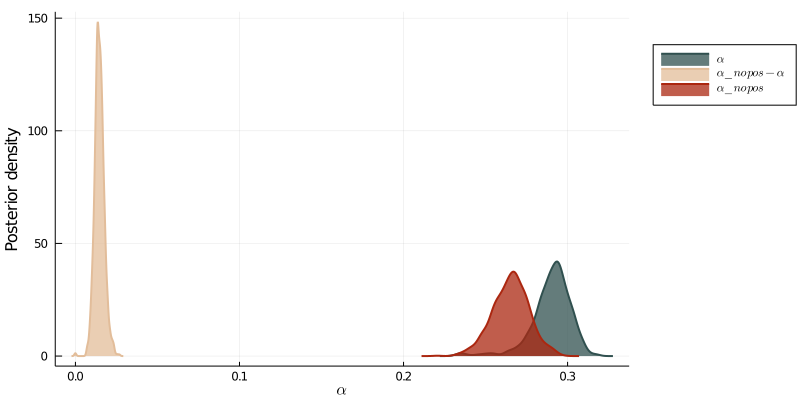

In [79]:
plotPosterior(vipP[1],(800,400))